In [1]:
import logging
import time
from platform import python_version
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import math
import datetime
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import bert ## Bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer ##Bert's own tokenizer
import seaborn as sns
from pylab import rcParams
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

In [3]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

train = train.append(valid).reset_index(drop=True)

train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [4]:
# train = pd.read_csv('atis_intents.csv')[:4000]
# test = pd.read_csv('atis_intents.csv')[4000:]
print(train.shape,test.shape) 

(13784, 2) (700, 2)


In [5]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [6]:
test.head()

,text,intent
0,add sabrina salerno to the grime instrumentals...,AddToPlaylist
1,i want to bring four people to a place that s ...,BookRestaurant
2,put lindsey cardinale into my hillary clinton ...,AddToPlaylist
3,will it snow in mt on june 13 2038,GetWeather
4,play signe anderson chant music that is newest,PlayMusic


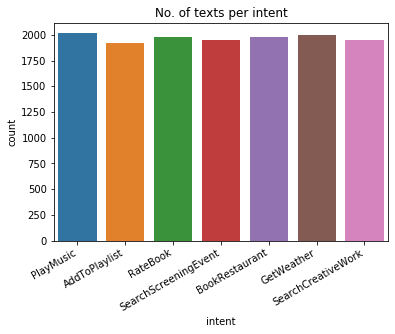

In [7]:
chart = sns.countplot(train.intent)
plt.title("No. of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation = 30, horizontalalignment='right');

In [8]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-06-25 17:07:16--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.240, 172.217.12.176, 172.217.165.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  6.59MB/s    in 97s     

2020-06-25 17:08:53 (4.00 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [9]:
columns_titles = ["text","intent"]
train=train.reindex(columns=columns_titles)
test=test.reindex(columns=columns_titles)

In [10]:
test.head()

,text,intent
0,add sabrina salerno to the grime instrumentals...,AddToPlaylist
1,i want to bring four people to a place that s ...,BookRestaurant
2,put lindsey cardinale into my hillary clinton ...,AddToPlaylist
3,will it snow in mt on june 13 2038,GetWeather
4,play signe anderson chant music that is newest,PlayMusic


In [11]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [12]:
os.makedirs("model", exist_ok=True)

In [13]:
!mv uncased_L-12_H-768_A-12/ model

In [14]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_checkpnt_dir = os.path.join("model/", bert_model_name)
bert_checkpnt_file = os.path.join(bert_checkpnt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_checkpnt_dir, "bert_config.json")

In [15]:
bert_checkpnt_file

'model/uncased_L-12_H-768_A-12/bert_model.ckpt'

In [16]:
class IntentDetectionData:
    DATA_COLUMN,  LABEL_COLUMN  = "text","intent"

    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
    
        for non, row in tqdm(df.iterrows()):
            text, label =\
                row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]

            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"] ## Tokens beigning and ending specified by separation of tokens.

            token_ids = self.tokenizer.convert_tokens_to_ids(tokens) ## Convert Tokens to IDs

            self.max_seq_len = max(self.max_seq_len, len(token_ids))

            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)] ## -2 as ignoring tokens provided by bert
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids)) ## padding by zeros
            x.append(np.array(input_ids))
        
        return np.array(x)

In [17]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_checkpnt_dir, 'vocab.txt'))

In [18]:
tokens = tokenizer.tokenize("Hello don't know if this is BERT! tokenizing random hello!")
print(tokens)

['hello', 'don', "'", 't', 'know', 'if', 'this', 'is', 'bert', '!', 'token', '##izing', 'random', 'hello', '!']


In [19]:
tokenizer.convert_tokens_to_ids(tokens)

[7592,
 2123,
 1005,
 1056,
 2113,
 2065,
 2023,
 2003,
 14324,
 999,
 19204,
 6026,
 6721,
 7592,
 999]

In [20]:
classes = train.intent.unique().tolist() ## Retreiving all the classes

In [21]:
def create_model(max_seq_len, bert_checkpnt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read()) ## Reading bert config
        bert_params = map_stock_config_to_params(bc) ## Mapping parameters 
        bert_params.adapter_size = None # Adapter size helps tune Bert model faster
        bert = BertModelLayer.from_params(bert_params, name="bert")

    ## Specifying input
    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)
    
    print("bert shape", bert_output.shape)

    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output) ## Preserve the first dimension; Done to get rid of higher dimension
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out) ##Flattening
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_checkpnt_file) ##Loading the weights from bert chckpoint file
        
    return model

In [22]:
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:06, 2207.56it/s]
700it [00:00, 2322.90it/s]


In [23]:
model = create_model(data.max_seq_len, bert_checkpnt_file)

bert shape (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa4d9e6cc50> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

In [25]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)##optimizer=keras.optimizers.Adam(1e-5)
histo = model.fit(x=data.train_x, y=data.train_y,validation_split=0.1,verbose = 1,batch_size=16,shuffle=True,epochs=1)

776/776 [==============================] - 4465s 6s/step - loss: 1.2956 - acc: 0.8832 - val_loss: 1.1849 - val_acc: 0.9811


In [26]:
non, test_acc = model.evaluate(data.test_x, data.test_y)
test_acc

22/22 [==============================] - 72s 3s/step - loss: 1.2008 - acc: 0.9657


0.9657142758369446

In [27]:
np.shape(classes)

(7,)

In [ ]:
y_pred = model.predict(data.test_x).argmax(axis = -1)

In [ ]:
tsting_sentence = [
    
    'Pay my favorite song', 
    'Add my favorite music to this playlist'
]
tokens = map(tokenizer.tokenize, tsting_sentence)
tokens = map(lambda tok:["[CLS]"] + tok + ["[SEP]"] , tokens)
token_ids = list(map(tokenizer.convert_tokens_to_ids, tokens))

token_ids = map(lambda toids: toids + [0]*(data.max_seq_len - len(toids)), token_ids)
token_ids = np.array(list(token_ids))


pred = model.predict(token_ids).argmax(-1)

for i, j in zip(tsting_sentence, pred):
    print("TEXT: ", i)  
    print("INTENT: ", classes[j])
    print(" Next Line")
    
    
    